### Step 1 - Setup

#### Import Libraries

In [78]:
import numpy as np 
import pandas as pd
import seaborn as sns
import os as os

import matplotlib.pyplot as plt

# Import the necessary libraries from sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report


# Import cv2 library for image viewing
import cv2
from google.colab.patches import cv2_imshow

# importing all the required sub-modules from keras
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam,RMSprop,Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
# The data set is stored on my Google Drive
# I will add a piece of code to allow Google Colab to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Loading Dataset

In [3]:
# Load the images from the numpy array file
images = np.load('/content/drive/My Drive/Colab Notebooks/Computer Vision/images.npy')

In [4]:
#Load the labels
labels=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Computer Vision/Labels.csv')

#### Printing Shape of Dataset

In [5]:
# Print the shape of the images and labels arrays
print('Images DataSet Shape', images.shape)
print ('Labels DataSet Shape', labels.shape)

Images DataSet Shape (4750, 128, 128, 3)
Labels DataSet Shape (4750, 1)


In [6]:
# There are 12 species so we have 12 classes
num_classes=12

#### Visualize Images

In [7]:
print (labels)

                          Label
0     Small-flowered Cranesbill
1     Small-flowered Cranesbill
2     Small-flowered Cranesbill
3     Small-flowered Cranesbill
4     Small-flowered Cranesbill
...                         ...
4745           Loose Silky-bent
4746           Loose Silky-bent
4747           Loose Silky-bent
4748           Loose Silky-bent
4749           Loose Silky-bent

[4750 rows x 1 columns]


In [8]:
# Print first image so we can see what that looks like
print (images[0])

[[[ 35  52  78]
  [ 36  49  76]
  [ 31  45  69]
  ...
  [ 78  95 114]
  [ 76  93 110]
  [ 80  95 109]]

 [[ 33  46  68]
  [ 37  50  73]
  [ 48  65  83]
  ...
  [ 81  96 113]
  [ 74  89 105]
  [ 83  95 109]]

 [[ 34  50  68]
  [ 35  52  72]
  [ 70  85 101]
  ...
  [ 83  97 112]
  [ 79  94 108]
  [ 79  94 107]]

 ...

 [[ 35  50  69]
  [ 42  57  73]
  [ 42  57  72]
  ...
  [ 60  76  92]
  [ 67  81  97]
  [ 64  77  95]]

 [[ 36  52  67]
  [ 48  63  78]
  [ 41  57  73]
  ...
  [ 44  66  83]
  [ 58  76  91]
  [ 57  74  90]]

 [[ 44  58  70]
  [ 43  57  73]
  [ 40  55  72]
  ...
  [ 41  70  92]
  [ 55  78  97]
  [ 61  79  96]]]


* Load Random images along with their labels as displaying 4750 is not practical



In [9]:
# Define this as a function as we will be calling it
# later to display the images after they are blurred out
def displayRandImages ():
  w = 10
  h = 10
  fig = plt.figure(figsize=(20, 20))
  index = 1
  columns = 4
  rows = 5
  randImages = np.random.randint(0,len(images)-1,20)
  for i in randImages:    
    ax = fig.add_subplot(rows, columns, index)      
    ax.set_title(labels.iloc[i][0])
    ax.axis('Off')    
    plt.imshow(images[i])
    index+=1

  plt.show()

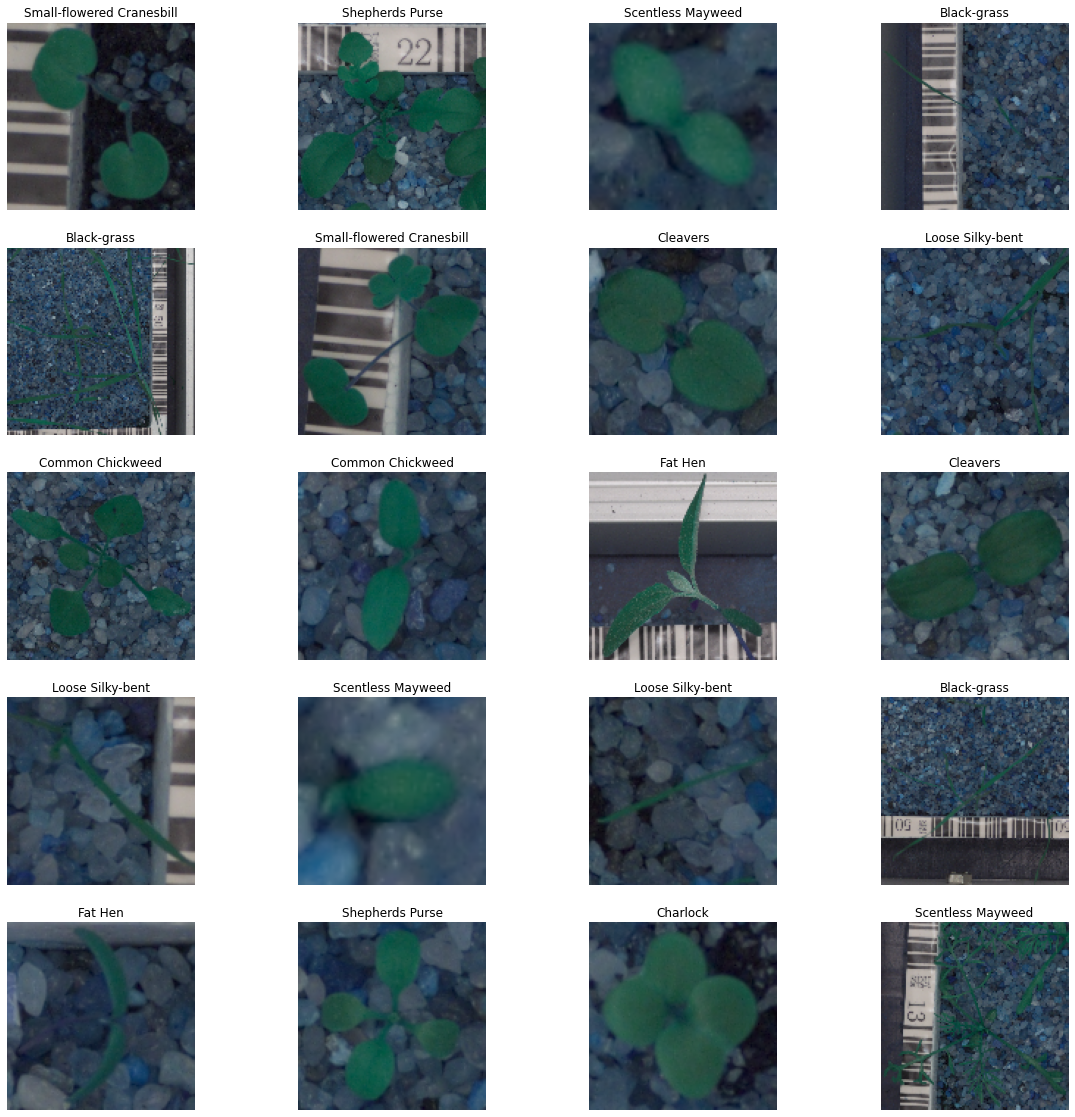

In [10]:
displayRandImages()

### Step 2 - Data Pre-Processing

#### Images Normalization

In [11]:
#Make sure the pixels are between 0 and 255
print('Pixels are between: ', images.min(), " and ", images.max())

# Check Data Type
print ('Data Type', images.dtype)


Pixels are between:  0  and  255
Data Type uint8


In [12]:
# Convert data type to float before normalizing
images = images.astype('float')

print ('Data Type', images.dtype)

Data Type float64


In [13]:
# Normalize pixels so all values will be between 0 and 1
images = images / 255

In [14]:
# Check the min value after normalization
images.min()

0.0

In [15]:
# Check max value after normalization
images.max()

1.0

In [16]:
# Out of curiosity, see what the distribution of images look like for each of the classes
duplicate_labels = labels.pivot_table(index=['Label'], aggfunc='size')
print (duplicate_labels)

Label
Black-grass                  263
Charlock                     390
Cleavers                     287
Common Chickweed             611
Common wheat                 221
Fat Hen                      475
Loose Silky-bent             654
Maize                        221
Scentless Mayweed            516
Shepherds Purse              231
Small-flowered Cranesbill    496
Sugar beet                   385
dtype: int64


#### Gaussian Blurring

In [17]:
# Applying Guassian Blurring on images to improve training
for i in range(len(images)):
 image = images[i]
 images[i] = cv2.GaussianBlur(image, (15, 15), 0)
  

#### Visualize Data After Pre-Processing

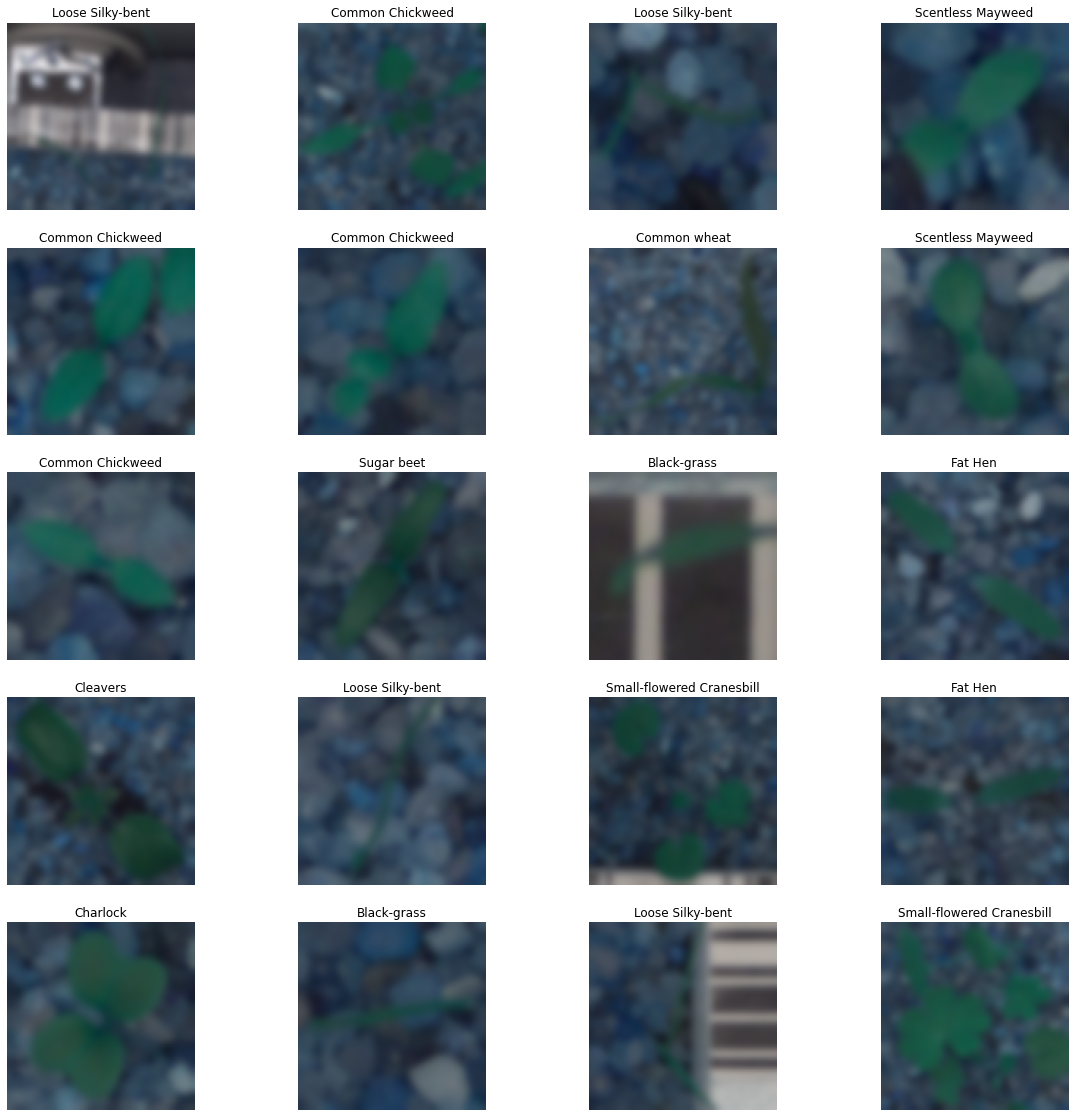

In [18]:
# It is not practical to display all 4750 images
# Will display few random images to show the effect of Guassian Blurring 

displayRandImages()

### Step 3 - Making Data Compatible

#### Convert Labels to One-Hot-Vectors

In [19]:
# We are using LabelBinarizer to convert labels to one-hot-vectors
labelBinarizer = LabelBinarizer()
label_data = labelBinarizer.fit_transform(labels)

#### Print the label for y_train[0]

In [20]:
# Show how one label looks like after getting encoded for y_train[0]
label_data[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [21]:
# Display the shape of encoded labels
print('Labels Shape Before One Hot Encoding', labels.shape)
print ('Labels Shape After One Hot Encoding', label_data.shape)

Labels Shape Before One Hot Encoding (4750, 1)
Labels Shape After One Hot Encoding (4750, 12)


#### Split the Dataset into Training, Testing, and Validation set.

* First, let's split the data into train and test
* Next will split test further into test and validation data

In [22]:
# Split the dataset into training, test, and validation
X_train,X_test,y_train,y_test=train_test_split(images,label_data,test_size=0.3,random_state=1)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(3325, 128, 128, 3) (1425, 128, 128, 3)
(3325, 12) (1425, 12)


In [23]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
print(X_test.shape,X_val.shape)
print(y_test.shape,y_val.shape)

(712, 128, 128, 3) (713, 128, 128, 3)
(712, 12) (713, 12)


The  shape of data is currently 128x128x3 which is not compatible with the default input size of transfer Keras models which by default it is 224x224.
We will go ahead and reshape the data so it is of shape 224x224x3.
We will use Tensor Flow Image Resize to resize the images from 128x128 to 224x224

In [24]:
# Reshape data 
reshaped_X_test = tf.image.resize(X_test,(224,224))
reshaped_X_train = tf.image.resize(X_train,(224,224))
reshaped_X_val = tf.image.resize(X_val,(224,224))


In [25]:
print("reshaped_X_test shape: ", reshaped_X_test.shape)
print("reshaped_X_train shape: ", reshaped_X_train.shape)
print("reshaped_X_val shape: ", reshaped_X_val.shape)

reshaped_X_test shape:  (712, 224, 224, 3)
reshaped_X_train shape:  (3325, 224, 224, 3)
reshaped_X_val shape:  (713, 224, 224, 3)


In [26]:
# Define the Input Shape for Keras Models
input_shape = (224, 224, 3)

### Step 4 - Building CNN Model
* We will attempt to build a CNN model from scratch using Keras Sequential
* Then, we will use model transfer to load two pre-trained models, VGG16 and ResNet50, and we will compare performance
* I will use shape 128x128 for the model built from scratch as Google Colab was crashing if I increase the shape to 224x224

#### Defining the Layers

* For the Feature Extractor section, we will have 2 convolution layers and one max pooling
* For the Classifier section, we will use one fully connected dense layer with 1000 units with ReLU as the activation function
*Finally, a softmax layer for the multi class prediction

In [27]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))



#### Visualizing the Layers, Inputs, and Outputs

#### Displaying the Model Summary

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 1000)              246017000 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0

Defining both the optimizer and loss function. Using Adam for the optimizer and categorical crossentropy for the loss

In [29]:
# initiate Adam optimizer
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [30]:
#Compile the model
model.compile(loss=losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

### Step 5 - Fitting and Evaludating CNN Model

In [33]:
# Determine an early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [34]:
#Training the model
cnn=model.fit(X_train,y_train,batch_size=128,epochs=20,verbose=1,validation_data=(X_val,y_val),shuffle=True,callbacks=[early_stopping])

Epoch 1/20
26/26 [==============================] - 40s 290ms/step - loss: 4.9737 - accuracy: 0.1203 - val_loss: 2.3506 - val_accuracy: 0.1683
Epoch 2/20
26/26 [==============================] - 5s 196ms/step - loss: 2.1455 - accuracy: 0.2662 - val_loss: 1.8208 - val_accuracy: 0.3717
Epoch 3/20
26/26 [==============================] - 5s 198ms/step - loss: 1.7428 - accuracy: 0.3865 - val_loss: 1.5990 - val_accuracy: 0.4264
Epoch 4/20
26/26 [==============================] - 5s 198ms/step - loss: 1.5955 - accuracy: 0.4331 - val_loss: 1.5100 - val_accuracy: 0.4797
Epoch 5/20
26/26 [==============================] - 5s 199ms/step - loss: 1.4950 - accuracy: 0.4737 - val_loss: 1.4387 - val_accuracy: 0.4811
Epoch 6/20
26/26 [==============================] - 5s 199ms/step - loss: 1.4085 - accuracy: 0.5131 - val_loss: 1.4004 - val_accuracy: 0.4965
Epoch 7/20
26/26 [==============================] - 5s 201ms/step - loss: 1.3402 - accuracy: 0.5362 - val_loss: 1.3321 - val_accuracy: 0.5330
Epoch

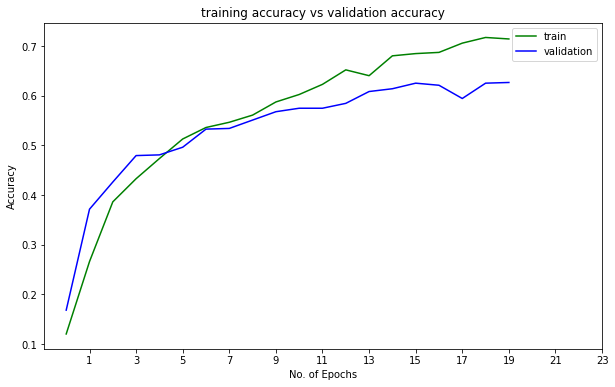

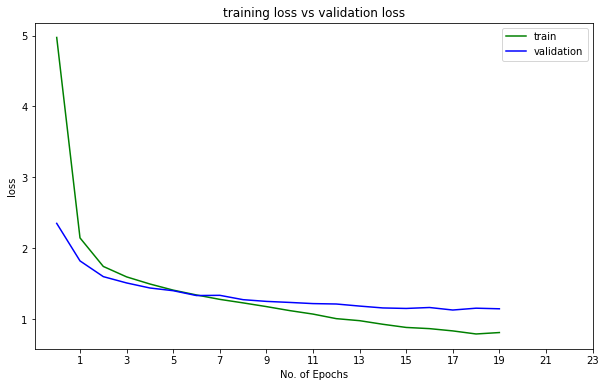

In [35]:
#Plots for training and validation process: loss and accuracy
plt.figure(figsize=(10,6))
plt.plot(cnn.history['accuracy'],'g')
plt.plot(cnn.history['val_accuracy'],'b')
plt.xticks(np.arange(1,25,2))
plt.title('training accuracy vs validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'])
plt.show()

plt.figure(figsize=(10,6))
plt.plot(cnn.history['loss'],'g')
plt.plot(cnn.history['val_loss'],'b')
plt.xticks(np.arange(1,25,2))
plt.title('training loss vs validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.show()

#### Insights
* Looks like epoch 14 seems to be the sweet spot both accuracy and val_accuracy are close to each other. However, the accuracy is still not good enough at 0.6
* As we pass epoch 14, the training accuracy seems to be getting better and better
* However, as we span epochs after epoch 5, the validation accuracy does not seem to be improving
* Similarly, loss beyond epoch 14 does not seem to be decreasing for validation, but it is decreasing for train
* the graphs tell us that beyond epoch 14, there seems to be overfitting on the training data

#### Predicting

In [36]:
#predict the model
pred=model.predict(X_test,verbose=1)

23/23 [==============================] - 1s 16ms/step


#### Building the Multi Class Confusion Matrix

In [37]:
confusion = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(pred,axis=1))
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[ 6  0  0  0  0  2 39  0  2  0  0  2]
 [ 0 32  4  0  0  5  0  0  1  3  3  1]
 [ 0  0 37  2  0  4  0  0  2  0  1  1]
 [ 0  2  1 68  0  3  0  1  1  4  2  4]
 [ 2  0  0  0  3  2 17  0  5  0  0  0]
 [ 0  1  1  5  0 57  1  0  1  1  2  5]
 [ 6  1  1  0  1  2 90  0  0  0  0  0]
 [ 0  1  2  7  1  0  0 15  4  0  2  3]
 [ 1  1  4  6  0  7  2  0 45  0  0  1]
 [ 0  0  3  9  0  4  0  0  9 14  2  0]
 [ 0  5  1  1  0  1  0  0  1  0 61  4]
 [ 0  1  3  1  0 25  2  1  3  0  2 20]]


* Let's build a more pretty multi-class confusion matrix with class labels

In [38]:
# Fetch all the classes
classes = labelBinarizer.classes_

In [39]:
# Display all 12 classes
classes

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25')

In [40]:
confusion_df = pd.DataFrame(confusion,
                     index = classes, 
                     columns = classes)

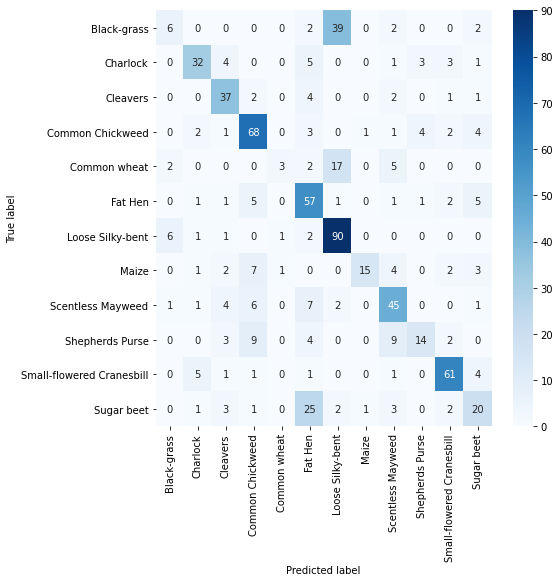

In [41]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

* Let's tune it a little bit more and build a normalized Confusion Matrix

In [42]:
confusion_norm = np.around(confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis], decimals=2)

In [43]:
confusion_norm_df = pd.DataFrame(confusion_norm,
                     index = classes, 
                     columns = classes)

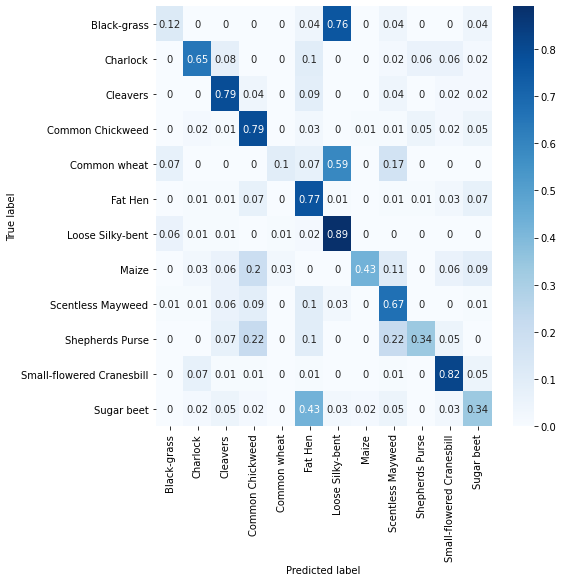

In [44]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_norm_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [83]:
print(classification_report(np.argmax(y_test,axis=1), np.argmax(pred,axis=1), target_names=classes))

                           precision    recall  f1-score   support

              Black-grass       0.40      0.12      0.18        51
                 Charlock       0.73      0.65      0.69        49
                 Cleavers       0.65      0.79      0.71        47
         Common Chickweed       0.69      0.79      0.74        86
             Common wheat       0.60      0.10      0.18        29
                  Fat Hen       0.51      0.77      0.61        74
         Loose Silky-bent       0.60      0.89      0.71       101
                    Maize       0.88      0.43      0.58        35
        Scentless Mayweed       0.61      0.67      0.64        67
          Shepherds Purse       0.64      0.34      0.44        41
Small-flowered Cranesbill       0.81      0.82      0.82        74
               Sugar beet       0.49      0.34      0.40        58

                 accuracy                           0.63       712
                macro avg       0.63      0.56      0.56    

#### Insights
* Highest Precision among all classes is for Maize at 0.88
* Highest Recall among all classes is for Loose Silky-bent at 0.89
* Highest True Positive among all classes per confusion matrix above by looking at the diagonal line is for Loose Silky-bent


### Step 6 - Visualize Predictions

In [45]:
# Decode the labels
pred_index=np.argmax(pred,axis=1)
pred_labels=labelBinarizer.classes_[pred_index]

In [46]:
pred_labels.shape

(712,)

In [47]:
test_index=np.argmax(y_test,axis=1)
test_labels=labelBinarizer.classes_[test_index]

In [48]:
test_labels.shape

(712,)

In [49]:
# This function is used to 
def get_image_index(image_name):
  flattened = test_labels.tolist()
  return flattened.index(image_name)

In [50]:
# Define this as a function as we will be calling it
# later to display the images after they are blurred out
def displayPredictions (pred_labels, test_labels):
  w = 10
  h = 10
  fig = plt.figure(figsize=(20, 20))
  index = 1
  columns = 2
  rows = 5
  for i in [2,3,33,36,59]:    
    ax = fig.add_subplot(rows, columns, index)      
    ax.set_title("Predicted Value at index " + str(i) + ": " + pred_labels[i])
    ax.axis('Off')    
    plt.imshow(X_test[get_image_index(pred_labels[i])])
    index+=1

    ax = fig.add_subplot(rows, columns, index)      
    ax.set_title("Actual Value at index " + str(i) + ": " + test_labels[i])
    ax.axis('Off')    
    plt.imshow(X_test[i])
    index+=1

  plt.show()

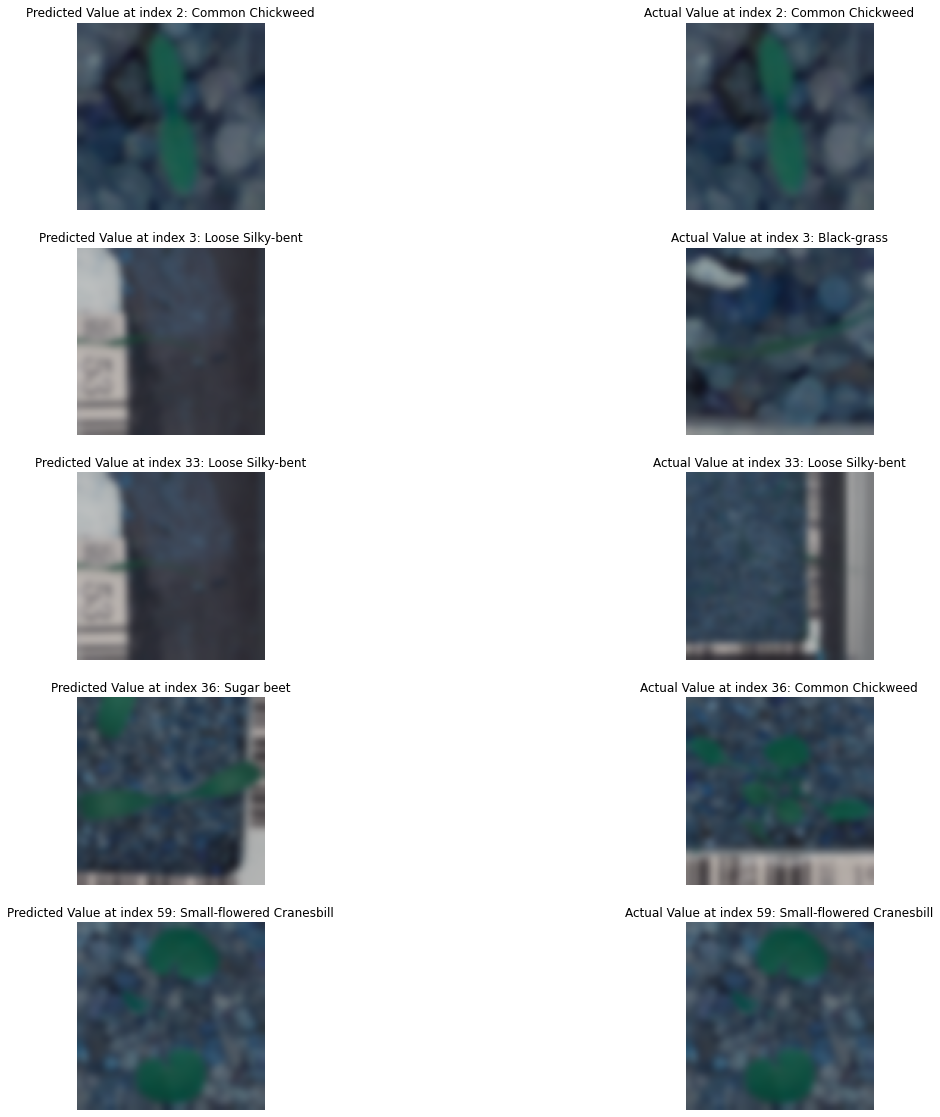

In [51]:
displayPredictions(pred_labels,test_labels)

In [52]:

print("Actual Value at index 2: ", test_labels[2],"\nPredicted Value at index 2: ", pred_labels[2])
print("\nActual Value at index 3: ", test_labels[3],"\nPredicted Value at index 3: ", pred_labels[3])
print("\nActual Value at index 33: ", test_labels[33],"\nPredicted Value at index 33: ", pred_labels[33])
print("\nActual Value at index 36: ", test_labels[36],"\nPredicted Value at index 36: ", pred_labels[36])
print("\nActual Value at index 59: ", test_labels[59],"\nPredicted Value at index 59: ", pred_labels[59])


Actual Value at index 2:  Common Chickweed 
Predicted Value at index 2:  Common Chickweed

Actual Value at index 3:  Black-grass 
Predicted Value at index 3:  Loose Silky-bent

Actual Value at index 33:  Loose Silky-bent 
Predicted Value at index 33:  Loose Silky-bent

Actual Value at index 36:  Common Chickweed 
Predicted Value at index 36:  Sugar beet

Actual Value at index 59:  Small-flowered Cranesbill 
Predicted Value at index 59:  Small-flowered Cranesbill


#### Summary
* predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59], we got 2 out of 5 wrong for x_test[3] and x_test[36]
* If we were to tune the model, we could try various things like modifying the hyperparamaters (number of filters, size of filter, number of stride, padding, etc...)
* Also, to tune the mode further, we could apply image processing, convert to grayscale and apply some data augmentation to see if that would help

### Step 7 - Model Building Using Tranfer Learning

#### Strategy
* Will remove the Classifier Layers which will contain the Fully connected dense layer and the classifiation layer
* We will keep the feature extractor layers intact
* We will freeze the feature extractor layers so the weights are not updated during model training
* We will use the already pre-trained model weights as feature extractor

#### Pre-Trained Models
* We will use two models to experiment with and compare performances: VGG16 and ResNet50

#### VGG16 Transfer Model

In [53]:
# Setting include_top as false, as we do not care if we lose the classifier block
# Since we will be adding our own.
vgg16_base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
vgg16_base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [54]:
# we will freeze all base model feature extraction layers so we do not 
# change them as we want to keep them same as how the model was trained
# This is the whole point of transfer learning - Take advantage of 
# what was trained and not train it from scratch
for layer in vgg16_base_model.layers:
    layer.trainable = False

In [55]:
for layer in vgg16_base_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [56]:
# Build on top of the VGG_16 Base Model
# Take the last layer of the base model to apped to it 
# the Classifier layers
# last_layer = vgg16_base_model.layers[-1].output
# # flattening the output of the VGG16 model
# layer = Flatten()(last_layer)
# layer = Dense(128, activation='relu', name="fc1")(layer)
# layer = Dropout(0.5) (layer)
# layer = Dense(num_classes, activation='softmax', name='predictions')

# transfered_model = Model(vgg16_base_model.input, layer)

last = vgg16_base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)
transfered_model = Model(vgg16_base_model.input, x)

In [57]:
# setting optimizer, loss function, and learning rate
optimizer = Adam(learning_rate=1e-4)
loss = 'binary_crossentropy'
metrics = ['accuracy']

In [58]:
transfered_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [59]:
transfered_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [60]:
#Training the model
trained_vgg_16=transfered_model.fit(reshaped_X_train,y_train,batch_size=128,epochs=40,verbose=1,validation_data=(reshaped_X_val,y_val),shuffle=True,callbacks=[early_stopping])

Epoch 1/40
26/26 [==============================] - 71s 2s/step - loss: 0.3305 - accuracy: 0.1290 - val_loss: 0.2772 - val_accuracy: 0.1851
Epoch 2/40
26/26 [==============================] - 17s 664ms/step - loss: 0.2789 - accuracy: 0.1663 - val_loss: 0.2672 - val_accuracy: 0.2440
Epoch 3/40
26/26 [==============================] - 17s 666ms/step - loss: 0.2674 - accuracy: 0.2271 - val_loss: 0.2627 - val_accuracy: 0.2623
Epoch 4/40
26/26 [==============================] - 17s 673ms/step - loss: 0.2602 - accuracy: 0.2812 - val_loss: 0.2552 - val_accuracy: 0.2749
Epoch 5/40
26/26 [==============================] - 17s 678ms/step - loss: 0.2535 - accuracy: 0.3041 - val_loss: 0.2502 - val_accuracy: 0.3254
Epoch 6/40
26/26 [==============================] - 17s 673ms/step - loss: 0.2460 - accuracy: 0.3546 - val_loss: 0.2465 - val_accuracy: 0.3282
Epoch 7/40
26/26 [==============================] - 17s 673ms/step - loss: 0.2444 - accuracy: 0.3480 - val_loss: 0.2460 - val_accuracy: 0.3072
Ep

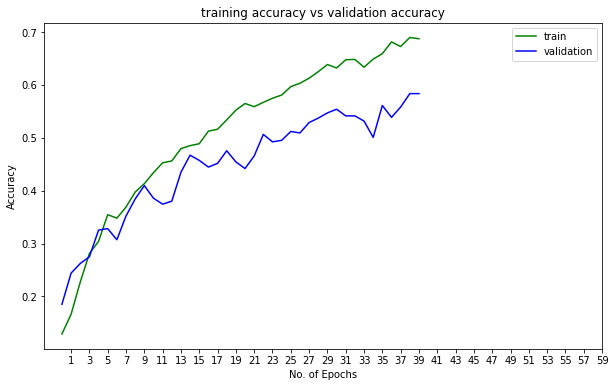

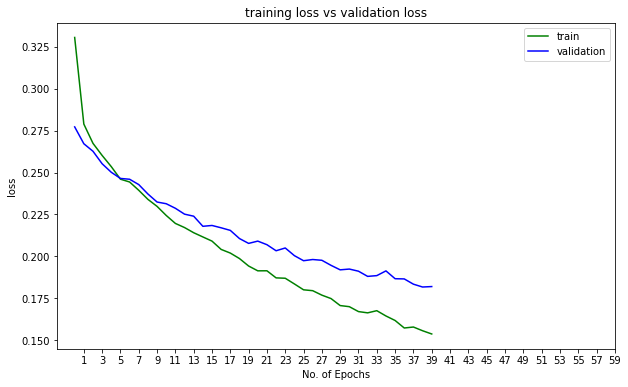

In [61]:
#Plots for training and validation process: loss and accuracy
plt.figure(figsize=(10,6))
plt.plot(trained_vgg_16.history['accuracy'],'g')
plt.plot(trained_vgg_16.history['val_accuracy'],'b')
plt.xticks(np.arange(1,60,2))
plt.title('training accuracy vs validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'])
plt.show()

plt.figure(figsize=(10,6))
plt.plot(trained_vgg_16.history['loss'],'g')
plt.plot(trained_vgg_16.history['val_loss'],'b')
plt.xticks(np.arange(1,60,2))
plt.title('training loss vs validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.show()

In [62]:
#predict the model
vgg16_predictions=transfered_model.predict(reshaped_X_test,verbose=1)

23/23 [==============================] - 11s 207ms/step


#### Visualize Predictions

In [63]:
prediction_index=np.argmax(vgg16_predictions,axis=1)
vgg16_prediction_labels=labelBinarizer.classes_[prediction_index]

In [64]:
vgg16_prediction_labels.shape

(712,)

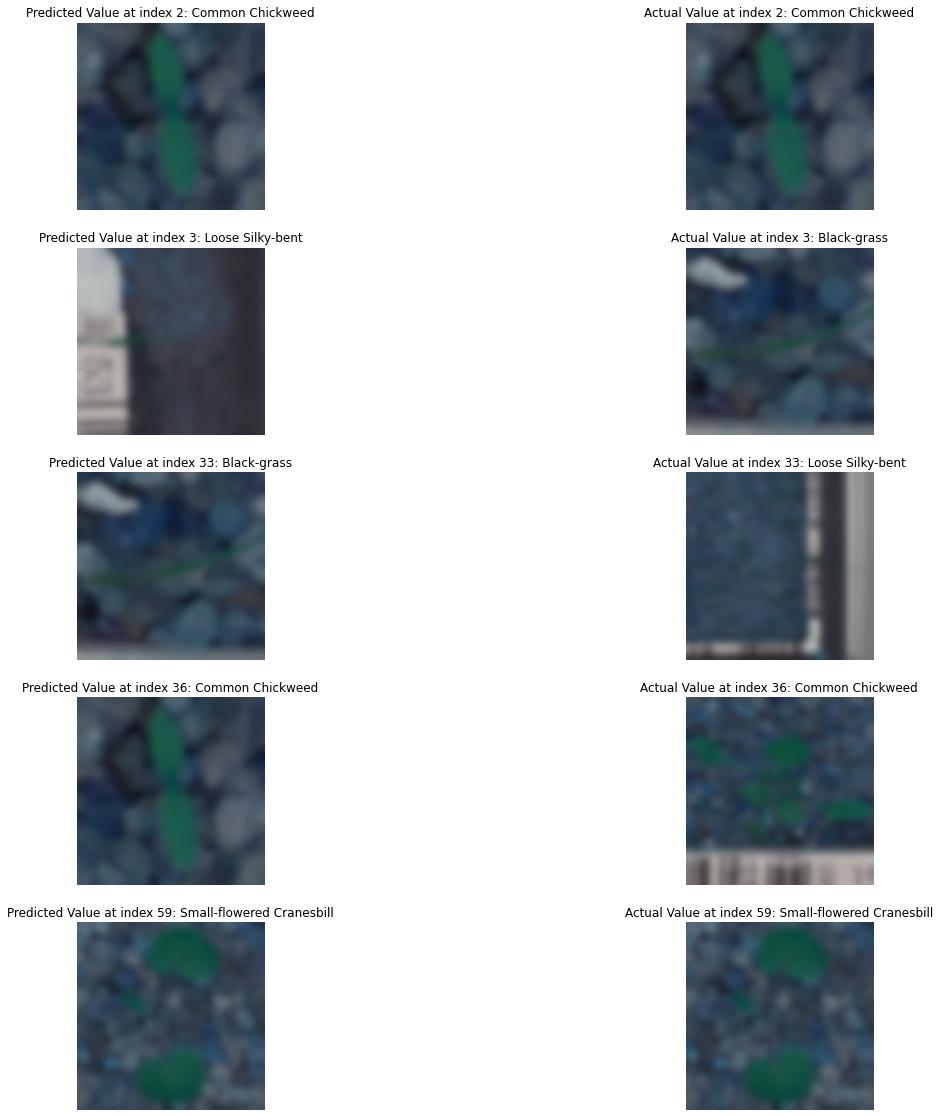

In [65]:
displayPredictions(vgg16_prediction_labels,test_labels)

#### VGG16 Summary
* Out of the 5 samples x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]., 2 were inditified incorrectly, x_test[3], x_test[33]
* Val_accuracy continued to stay below 0.6


#### ResNet50 Transfer Model

In [66]:
# Setting include_top as false, so we can specify the input shape that matches our image dimension
# We do not care if we lose the classifier layers (Fully connected and output layers) as we will add our own.
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
resnet.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [67]:
# we will freeze all base model feature extraction layers so we do not 
# change them as we want to keep them same as how the model was trained
# This is the whole point of transfer learning - Take advantage of 
# what was trained and not train it from scratch
for layer in resnet.layers:
    layer.trainable = False

In [68]:
# Confirm the layers were frozen for edits
for layer in resnet.layers:
    print(layer.name, layer.trainable)

input_2 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [69]:
# Build on top of the VGG_16 Base Model
# Take the last layer of the base model to apped to it 
# the Classifier layers
last = resnet.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)
resnet_transfered_model = Model(resnet.input, x)

In [70]:
# setting optimizer, loss function, and learning rate
optimizer = Adam(learning_rate=1e-4)
loss = 'binary_crossentropy'
metrics = ['accuracy']

In [71]:
resnet_transfered_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [72]:
resnet_transfered_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [73]:
#Training the model
trained_resnet=resnet_transfered_model.fit(reshaped_X_train,y_train,batch_size=128,epochs=40,verbose=1,validation_data=(reshaped_X_val,y_val),shuffle=True,callbacks=[early_stopping])

Epoch 1/40
26/26 [==============================] - 23s 685ms/step - loss: 0.4607 - accuracy: 0.0989 - val_loss: 0.2917 - val_accuracy: 0.1332
Epoch 2/40
26/26 [==============================] - 14s 532ms/step - loss: 0.3007 - accuracy: 0.1080 - val_loss: 0.2861 - val_accuracy: 0.1122
Epoch 3/40
26/26 [==============================] - 14s 527ms/step - loss: 0.2908 - accuracy: 0.1182 - val_loss: 0.2815 - val_accuracy: 0.0968
Epoch 4/40
26/26 [==============================] - 13s 515ms/step - loss: 0.2894 - accuracy: 0.1164 - val_loss: 0.2817 - val_accuracy: 0.1178
Epoch 5/40
26/26 [==============================] - 13s 510ms/step - loss: 0.2906 - accuracy: 0.1122 - val_loss: 0.2814 - val_accuracy: 0.1557
Epoch 6/40
26/26 [==============================] - 13s 508ms/step - loss: 0.2901 - accuracy: 0.1239 - val_loss: 0.2865 - val_accuracy: 0.1234
Epoch 7/40
26/26 [==============================] - 13s 506ms/step - loss: 0.2900 - accuracy: 0.1254 - val_loss: 0.2812 - val_accuracy: 0.1683

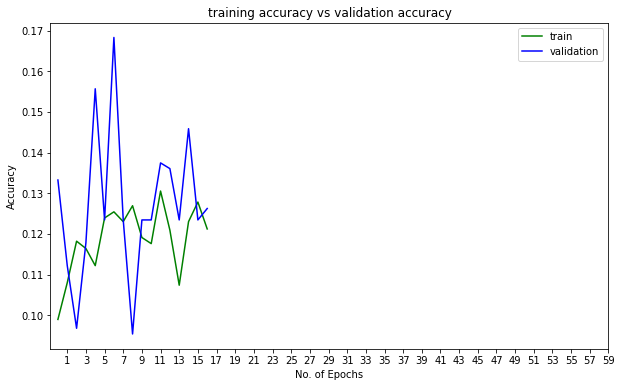

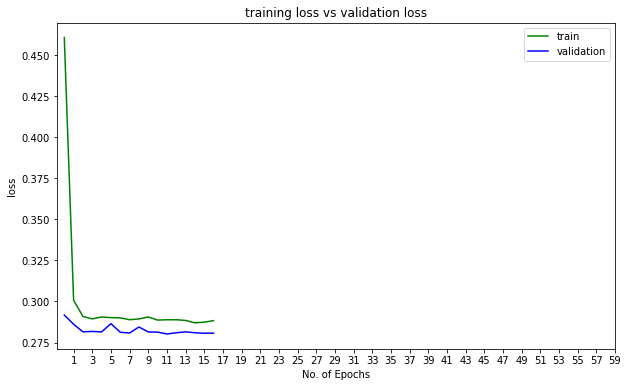

In [74]:
#Plots for training and validation process: loss and accuracy
plt.figure(figsize=(10,6))
plt.plot(trained_resnet.history['accuracy'],'g')
plt.plot(trained_resnet.history['val_accuracy'],'b')
plt.xticks(np.arange(1,60,2))
plt.title('training accuracy vs validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'])
plt.show()

plt.figure(figsize=(10,6))
plt.plot(trained_resnet.history['loss'],'g')
plt.plot(trained_resnet.history['val_loss'],'b')
plt.xticks(np.arange(1,60,2))
plt.title('training loss vs validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.show()

#### Predict Labels

In [75]:
#predict the model
resnet_predictions=resnet_transfered_model.predict(reshaped_X_test,verbose=1)

23/23 [==============================] - 4s 113ms/step


#### Visualize Predictions

In [76]:
prediction_index=np.argmax(resnet_predictions,axis=1)
prediction_labels=labelBinarizer.classes_[prediction_index]

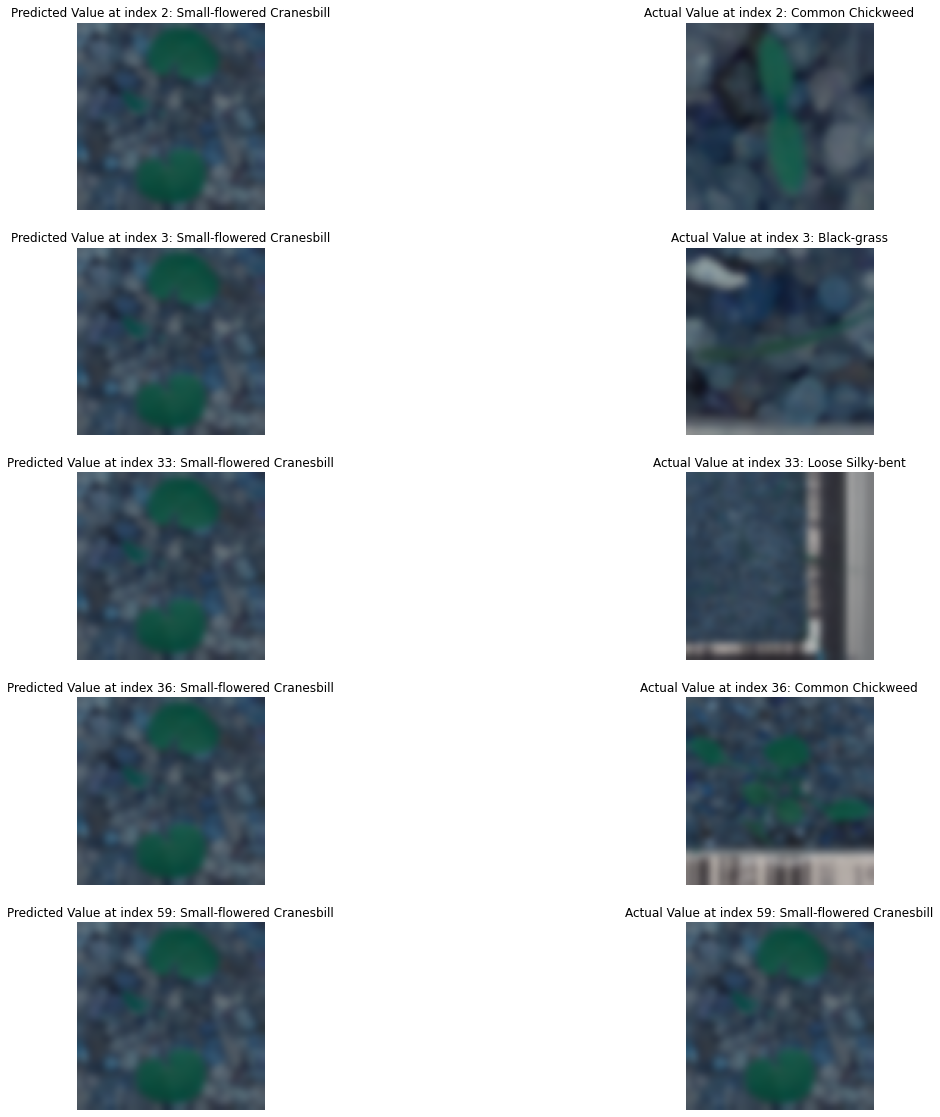

In [77]:
displayPredictions(prediction_labels,test_labels)

#### Insights
* ResNet50 performed very poorly in identifying plant seedlings. Out of 5 sampled out, it was able to identify 1 correctly.
* Looks like it was identifying all images as small-flowered Cranesbill
* The accuracy and val_accuracy continued to be very low despite the number of epochs

#### Summary
* The accuracy was fluctuating a lot
* I was able to get better accuracy for the Sequential mode however at some point, overfitting starts to dominate
* Overall, I would choose a pre-trained model and work on training the classifier block really well.